In [1]:
import os
import random
import pandas as pd
from sklearn.model_selection import train_test_split

# Config
root_dir = r"C:\Users\hp\Desktop\121ME0017\blnw-images-224"
class_names = ["bolt", "locatingpin", "nut", "washer"]
samples_per_class = 500

# Collect image paths and labels
data = []
for label in class_names:
    folder = os.path.join(root_dir, label)
    all_images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    selected_images = random.sample(all_images, samples_per_class)
    data.extend([(img, label) for img in selected_images])

# Create DataFrame and shuffle
df = pd.DataFrame(data, columns=['image_path', 'label'])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

# Split
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Save CSVs
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

print("CSV files created: train.csv, val.csv, test.csv")


CSV files created: train.csv, val.csv, test.csv


In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class ImageCSVLoader(Dataset):
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.df['label'].unique()))}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        label_str = self.df.iloc[idx, 1]
        label = self.label_map[label_str]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label


In [3]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageCSVLoader("train.csv", transform=transform)
val_dataset = ImageCSVLoader("val.csv", transform=transform)
test_dataset = ImageCSVLoader("test.csv", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



In [4]:
import torchvision.models as models
import torch.nn as nn

def get_model(name, num_classes):
    if name == "alexnet":
        model = models.alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif name == "vgg":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif name == "googlenet":
        model = models.googlenet(pretrained=True)
        model.fc = nn.Linear(1024, num_classes)
    elif name == "resnet":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "densenet":
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "efficientnet":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError("Invalid model name")
    return model




Training ALEXNET


D:\anan\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anan\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/2] Loss: 0.4626
Epoch [2/2] Loss: 0.1494
Validation Results:
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98        75
    Overload       1.00      0.95      0.97        75
  Mechanical       0.96      1.00      0.98        75
  Electrical       1.00      1.00      1.00        75

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

Test Results:
              precision    recall  f1-score   support

      Normal       0.88      0.96      0.92        75
    Overload       0.92      0.79      0.85        75
  Mechanical       0.94      0.99      0.96        75
  Electrical       0.99      0.99      0.99        75

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



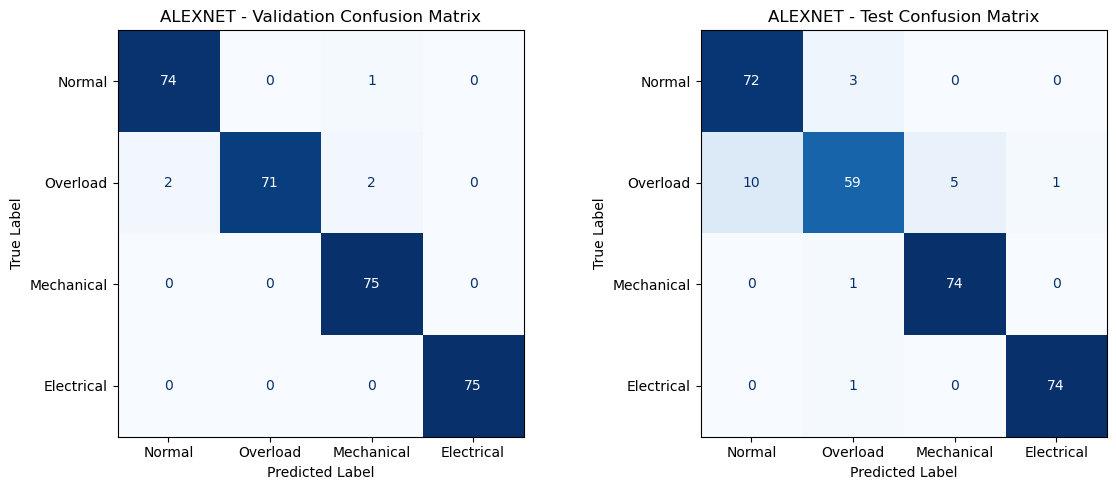


Training VGG


D:\anan\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anan\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create plots directory
os.makedirs("plots", exist_ok=True)

# Store accuracy results
model_scores = {
    "model": [],
    "validation_accuracy": [],
    "test_accuracy": []
}

# Example class names (update this list based on your dataset)
class_names = ['Normal', 'Overload', 'Mechanical', 'Electrical']
label_map = {i: name for i, name in enumerate(class_names)}

# Confusion Matrix Display
def plot_conf_matrix(val_labels, val_preds, test_labels, test_preds, model_name):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Validation Confusion Matrix
    ConfusionMatrixDisplay(confusion_matrix(val_labels, val_preds),
                           display_labels=list(label_map.values())).plot(ax=ax[0], colorbar=False, cmap='Blues', values_format='d')
    ax[0].set_title(f'{model_name.upper()} - Validation Confusion Matrix')
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")

    # Test Confusion Matrix
    ConfusionMatrixDisplay(confusion_matrix(test_labels, test_preds),
                           display_labels=list(label_map.values())).plot(ax=ax[1], colorbar=False, cmap='Blues', values_format='d')
    ax[1].set_title(f'{model_name.upper()} - Test Confusion Matrix')
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")

    plt.tight_layout()
    plt.savefig(f"plots/{model_name.lower()}_combined_conf_matrix.png")
    plt.show()

# Training and evaluation function
def train_and_eval(model_name):
    print(f"\nTraining {model_name.upper()}")
    model = get_model(model_name, num_classes=4).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Training loop
    for epoch in range(2):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/2] Loss: {running_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    print("Validation Results:")
    print(classification_report(val_labels, val_preds, target_names=class_names))

    # Test
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    print("Test Results:")
    print(classification_report(test_labels, test_preds, target_names=class_names))

    # Plot and save combined confusion matrices
    plot_conf_matrix(val_labels, val_preds, test_labels, test_preds, model_name)

    # Store model accuracy scores
    model_scores["model"].append(model_name.upper())
    model_scores["validation_accuracy"].append(val_acc)
    model_scores["test_accuracy"].append(test_acc)

# Loop over all models
for model_name in ["alexnet", "vgg", "googlenet", "resnet", "densenet", "efficientnet"]:
    train_and_eval(model_name)

# Plot accuracy comparison
def plot_accuracy_comparison(model_scores):
    x = np.arange(len(model_scores["model"]))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    val_bars = ax.bar(x - width/2, model_scores["validation_accuracy"], width, label='Validation Accuracy')
    test_bars = ax.bar(x + width/2, model_scores["test_accuracy"], width, label='Test Accuracy')

    # Annotate bars
    for bar in val_bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    for bar in test_bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Model')
    ax.set_title('Model Accuracy Comparison (Validation vs Test)')
    ax.set_xticks(x)
    ax.set_xticklabels(model_scores["model"])
    ax.legend()
    plt.tight_layout()
    plt.savefig("plots/accuracy_comparison.png")
    plt.show()

plot_accuracy_comparison(model_scores)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create plots directory
os.makedirs("plots", exist_ok=True)

# Store accuracy results
model_scores = {
    "model": [],
    "validation_accuracy": [],
    "test_accuracy": []
}

# Plot confusion matrix and save
def plot_conf_matrix(y_true, y_pred, class_names, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f"plots/{filename}.png")
    plt.show()

# Training and evaluation
def train_and_eval(model_name):
    print(f"\nTraining {model_name.upper()}")
    model = get_model(model_name, num_classes=4).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Training loop
    for epoch in range(2):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/2] Loss: {running_loss/len(train_loader):.4f}")

    # ======= Validation =======
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    print("Validation Results:")
    print(classification_report(val_labels, val_preds, target_names=class_names))
    plot_conf_matrix(val_labels, val_preds, class_names, 
                     f"{model_name.upper()} - Validation Confusion Matrix", 
                     f"{model_name.lower()}_val_conf_matrix")

    # ======= Test =======
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    print("Test Results:")
    print(classification_report(test_labels, test_preds, target_names=class_names))
    plot_conf_matrix(test_labels, test_preds, class_names, 
                     f"{model_name.upper()} - Test Confusion Matrix", 
                     f"{model_name.lower()}_test_conf_matrix")

    # Store model accuracy scores
    model_scores["model"].append(model_name.upper())
    model_scores["validation_accuracy"].append(val_acc)
    model_scores["test_accuracy"].append(test_acc)

# Train and evaluate all models
for model_name in ["alexnet", "vgg", "googlenet", "resnet", "densenet", "efficientnet"]:
    train_and_eval(model_name)

# ======= Accuracy Bar Plot and Save =======
def plot_accuracy_comparison(model_scores):
    x = np.arange(len(model_scores["model"]))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    val_bars = ax.bar(x - width/2, model_scores["validation_accuracy"], width, label='Validation Accuracy')
    test_bars = ax.bar(x + width/2, model_scores["test_accuracy"], width, label='Test Accuracy')

    # Annotate scores on top
    for bar in val_bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    for bar in test_bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Model')
    ax.set_title('Model Accuracy Comparison (Validation vs Test)')
    ax.set_xticks(x)
    ax.set_xticklabels(model_scores["model"])
    ax.legend()
    plt.tight_layout()
    plt.savefig("plots/accuracy_comparison.png")
    plt.show()

plot_accuracy_comparison(model_scores)
